In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

yf.pdr_override()

y_symbols = ['^GSPC', '^MXX', '^FCHI','^NYA','^JKSE', '^RUT','^KS11' ]

start_date = dt.datetime(2000,1,1)
end_date = dt.datetime(2020,1,2)

data = pdr.get_data_yahoo(y_symbols, start=start_date, end=end_date, interval='1mo')['Adj Close']

[*********************100%***********************]  7 of 7 completed


In [2]:
data

,^FCHI,^GSPC,^JKSE,^KS11,^MXX,^NYA,^RUT
Date,,,,,,,
2000-01-01,5659.810059,1394.459961,636.372009,943.880005,6585.669922,6574.009766,496.230011
2000-02-01,6190.959961,1366.420044,576.541992,828.380005,7368.549805,6266.419922,577.710022
2000-03-01,6286.049805,1498.579956,583.276001,860.940002,7473.250000,6848.609863,539.090027
2000-04-01,6419.720215,1452.430054,526.737000,725.390015,6640.680176,6811.169922,506.250000
2000-05-01,6426.259766,1420.599976,454.326996,731.880005,5961.140137,6805.250000,476.179993
...,...,...,...,...,...,...,...
2019-09-01,5677.790039,2976.739990,6169.102051,2063.050049,43011.269531,13004.740234,1523.369995
2019-10-01,5729.859863,3037.560059,6228.316895,2083.479980,43337.281250,13171.809570,1562.449951
2019-11-01,5905.169922,3140.979980,6011.830078,2087.959961,42820.179688,13545.209961,1624.500000


In [3]:
#conversions
# convert in USD, we will use fixed rates
data.iloc[:,0] = data.iloc[:,0]* 1.06      #FCHI
data.iloc[:,4] = data.iloc[:,4]* 0.05      #MXX
data.iloc[:,2] = data.iloc[:,2]* 0.000064  #JKSE
data.iloc[:,3] = data.iloc[:,3]* 0.000773  #KS11

In [4]:
data

,^FCHI,^GSPC,^JKSE,^KS11,^MXX,^NYA,^RUT
Date,,,,,,,
2000-01-01,5999.398662,1394.459961,0.040728,0.729619,329.283496,6574.009766,496.230011
2000-02-01,6562.417559,1366.420044,0.036899,0.640338,368.427490,6266.419922,577.710022
2000-03-01,6663.212793,1498.579956,0.037330,0.665507,373.662500,6848.609863,539.090027
2000-04-01,6804.903428,1452.430054,0.033711,0.560726,332.034009,6811.169922,506.250000
2000-05-01,6811.835352,1420.599976,0.029077,0.565743,298.057007,6805.250000,476.179993
...,...,...,...,...,...,...,...
2019-09-01,6018.457441,2976.739990,0.394823,1.594738,2150.563477,13004.740234,1523.369995
2019-10-01,6073.651455,3037.560059,0.398612,1.610530,2166.864063,13171.809570,1562.449951
2019-11-01,6259.480117,3140.979980,0.384757,1.613993,2141.008984,13545.209961,1624.500000


In [95]:
a = {}

In [96]:
returns = (data / data.shift(1))[1:12*10] #shift it's like previous period so I have from p[2...12] / p[1 ...11]
logReturns = np.log(returns)

yearly_mean = 12 * logReturns.mean()
yearly_var = 12 * logReturns.var()
yearly_std = np.sqrt(yearly_var)
yearly_cov = 12 * logReturns.cov()

a['1'] = logReturns

In [102]:
# 10 years sliding window
sliding_windows_data = {}

for j in range(11):
    i=12 *j
    returns = (data / data.shift(1))[1+i:12*10 +i] 
    logReturn = np.log(returns)

    yearly_mean = 12 * logReturn.mean()
    yearly_var = 12 * logReturn.var()
    yearly_std = np.sqrt(yearly_var)
    yearly_cov = 12 * logReturn.cov()
    
    sliding_windows_data[str(j+1) +'_yearly_mean'] = yearly_mean
    sliding_windows_data[str(j+1) +'_yearly_var'] = yearly_var
    sliding_windows_data[str(j+1) +'_yearly_std'] = yearly_std
    sliding_windows_data[str(j+1) +'_yearly_cov'] = yearly_cov

In [107]:
#expected yearly returns:
for j in range(11):
    print("SLIDING WINDOW ", j+1)
    print(sliding_windows_data[str(j+1) +'_yearly_mean'])
    print("____________________________________________________________")

SLIDING WINDOW  1
^FCHI   -0.036619
^GSPC   -0.022544
^JKSE    0.139352
^KS11    0.058306
^MXX     0.159791
^NYA     0.008961
^RUT     0.023328
dtype: float64
____________________________________________________________
SLIDING WINDOW  2
^FCHI   -0.045908
^GSPC   -0.008335
^JKSE    0.218168
^KS11    0.120982
^MXX     0.179562
^NYA     0.012764
^RUT     0.043645
dtype: float64
____________________________________________________________
SLIDING WINDOW  3
^FCHI   -0.034796
^GSPC    0.010771
^JKSE    0.215360
^KS11    0.089974
^MXX     0.169155
^NYA     0.020247
^RUT     0.043126
dtype: float64
____________________________________________________________
SLIDING WINDOW  4
^FCHI    0.021639
^GSPC    0.051513
^JKSE    0.242833
^KS11    0.122638
^MXX     0.201011
^NYA     0.055520
^RUT     0.083205
dtype: float64
____________________________________________________________
SLIDING WINDOW  5
^FCHI    0.016751
^GSPC    0.049521
^JKSE    0.175096
^KS11    0.087034
^MXX     0.152377
^NYA     0.0

In [108]:
#cov_matrices:
for j in range(11):
    print("SLIDING WINDOW ", j+1)
    print(sliding_windows_data[str(j+1) +'_yearly_cov'])
    print("____________________________________________________________")

SLIDING WINDOW  1
          ^FCHI     ^GSPC     ^JKSE     ^KS11      ^MXX      ^NYA      ^RUT
^FCHI  0.038300  0.027418  0.020039  0.031955  0.028518  0.026655  0.033560
^GSPC  0.027418  0.026898  0.022144  0.029860  0.026601  0.026041  0.029215
^JKSE  0.020039  0.022144  0.072984  0.041865  0.036686  0.024640  0.029809
^KS11  0.031955  0.029860  0.041865  0.075839  0.040467  0.029067  0.036298
^MXX   0.028518  0.026601  0.036686  0.040467  0.049517  0.025777  0.037805
^NYA   0.026655  0.026041  0.024640  0.029067  0.025777  0.027178  0.028480
^RUT   0.033560  0.029215  0.029809  0.036298  0.037805  0.028480  0.048064
____________________________________________________________
SLIDING WINDOW  2
          ^FCHI     ^GSPC     ^JKSE     ^KS11      ^MXX      ^NYA      ^RUT
^FCHI  0.039682  0.029465  0.023861  0.035396  0.028284  0.029581  0.034554
^GSPC  0.029465  0.027883  0.023425  0.029055  0.025710  0.027829  0.032200
^JKSE  0.023861  0.023425  0.066836  0.035262  0.032587  0.027091  

#### Efficient frontiers

C:\Users\fiori\AppData\Local\Temp\ipykernel_12820\4269741943.py:18: RuntimeWarning: invalid value encountered in divide
  weights /= np.sum(weights)


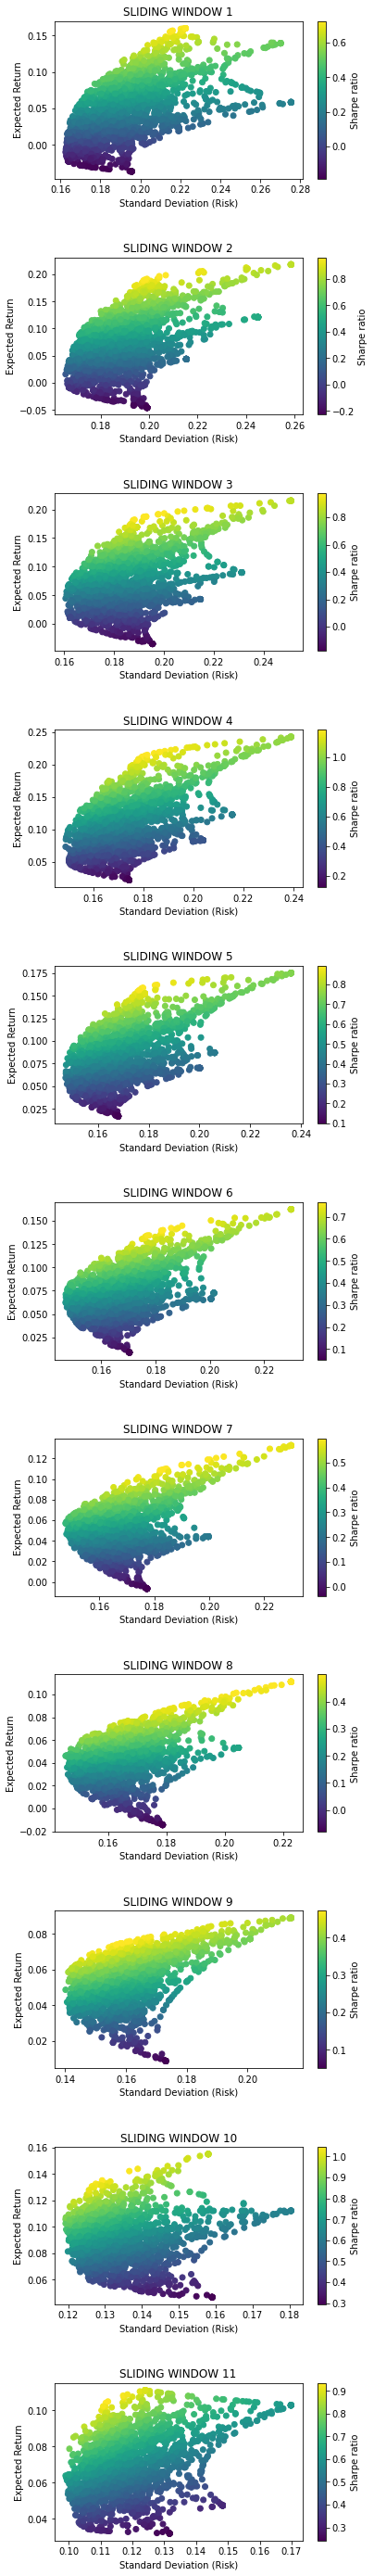

In [229]:
import numpy as np
import matplotlib.pyplot as plt

 #take a list of lists of frontier returns and variances
f_r = []
f_v = []

for j in range(11):
    returns = sliding_windows_data[str(j+1) +'_yearly_mean']
    covariances = sliding_windows_data[str(j+1) +'_yearly_cov']

    frontier_mean_returns = []
    frontier_variances = []

    for i in range(2000):
        weights = np.random.normal(0, 1, size=7) #use normal distribution
        weights = [x if x >= 0 else 0 for x in weights]  
        weights /= np.sum(weights)
        portfolio_return = np.sum(returns * weights)
        portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(covariances, weights)))
        frontier_mean_returns.append(portfolio_return)
        frontier_variances.append(portfolio_variance)
    f_r.append(frontier_mean_returns)
    f_v.append(frontier_variances)
    

    
# Create a figure and a 3x3 grid of subplots
fig, axs = plt.subplots(11, figsize=(6, 50))

# Loop through the subplots and plot something on each of them
for i in range(11):
    im = axs[i].scatter(f_v[i], f_r[i], c=(np.array(f_r[i]) / np.array(f_v[i])))
    axs[i].set_xlabel('Standard Deviation (Risk)')
    axs[i].set_ylabel('Expected Return')
    plt.colorbar(im, ax=axs[i], label = 'Sharpe ratio')
    
count = 0
for ax in axs.flat:
    count +=1
    ax.set_title("SLIDING WINDOW " + str(count))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
# Show the plot
plt.show()

